# Bayesian linear regression with variational inference (VI)

__Objective:__ manually implement the _Bayes by backprop_ algorithm for a linear regression problem.

Model: given data $(x_i, y_i)$ we want to model $y$ as a function of $x$ and we take
- Gaussian likelihood centered around a linear function of $x$:
$$
y \sim p(y | a, b, \sigma) = \mathcal{N}\left( y | \mu = a x + b, \sigma \right).
$$

(Note: we treat the $\sigma$ parameter of the likelihood as fixed (no fit over it), so we'll omit it from now on.)

- Unit Gaussian priors over the parameters $a$ and $b$:
$$
p(a) = p(b) = \mathcal{N}(0, 1)\,.
$$

- Gaussian variational distributions (approximating the posterior distributions for $a$ and $b$):
$$
\begin{array}{l}
q_{\mu_a, \sigma_a}(a) = \mathcal{N}\left( a | \mu_a, \sigma_a \right), \\
q_{\mu_b, \sigma_b}(b) = \mathcal{N}\left( b | \mu_b, \sigma_b\right).
\end{array}
$$

The parameters over which we optimize are $\mu_a$, $\sigma_a$, $\mu_b$, $\sigma_b$, expressed in terms of 4 weights $w_0, \ldots, w_3$ as
$$
\begin{array}{l}
\mu_a = w_0 \\
\sigma_a = \text{softplus}(w_1) \\
\mu_b = w_2 \\
\sigma_b = \text{softplus}(w_3)
\end{array}
$$

Following the Bayes by backprop algorithm, the loss function to optimize is
$$
\text{Loss} = \text{Loss}_\text{KL} + \text{Loss}_{NLL},
$$
with

$$
\begin{array}{l}
\text{Loss}_\text{KL} = \sum_{i\in \lbrace a, b \rbrace} \text{KL} \left[ \mathcal{N} (\theta_i | \mu_i, \sigma_i ) \vert\vert \mathcal{N}( \theta_i \vert\vert 0, 1 ) \right] = - \frac{1}{2} \left( 1 + \log(\sigma_i^2) - \sigma_i^2 - \mu_i^2 \right), \\
\text{Loss}_\text{NLL} = - \mathbb{E}_{\theta_i \sim \mathcal{N}(\mu_i, \sigma_i)} \left[ \log(p(D \vert a, b)) \right] \simeq - \frac{1}{N} \sum_{j=1}^{N} \log(p(D \vert a_j, b_j))
\end{array}
$$

and where $\theta_a \equiv a$, $\theta_b \equiv b$ and $(a_1, b_1), \ldots, (a_N, b_N)$ are $N$ samples of $a$ and $b$ from the variational distributions given the current parameters $\mu_i$ and $\sigma_i$.

The loss function comes from requiring that the optimal values for the variational parameters $\lambda = (\mu_a, \sigma_a, \mu_b, \sigma_b)$ are obtained by minimizing the KL divergence between the variational distributions used to approximate the true posterior $p(\theta | D)$ and the true posterior itself:
$$
\lambda^\star = \text{argmin}_\lambda \left( \text{KL} \left[ q_\lambda(\theta)\, \vert\vert\, p(\theta | D) \right] \right)
$$

Using Bayes' theorem to rewrite the true posterior the loss function is split into three terms:
- $\text{loss}_\text{KL}$: KL divergence between the variational posterior (a univariate Gaussians with trainable $\mu$ and $\sigma$ for each parameter, independent between the parameters) and the prior (a unit univariate Gaussian for each parameter, again independent between the parameters).
- $\text{loss}_\text{NLL}$: negative log likelihood of the data w.r.t. to the variational distributions, summed over all datapoints.
- A term independent from $\lambda$ which can be therefore dropped.

__Note:__ because the variational distributions for the parameters are assumed to be independent, the full variational distribution is just their product. The same is true for the priors. This fact causes $\text{loss}_\text{KL}$ to be a sum over independent contributions coming from the different parameters.

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import seaborn as sns

tfd = tfp.distributions

sns.set_theme()

## Generate data

Text(0.5, 1.0, 'Data')

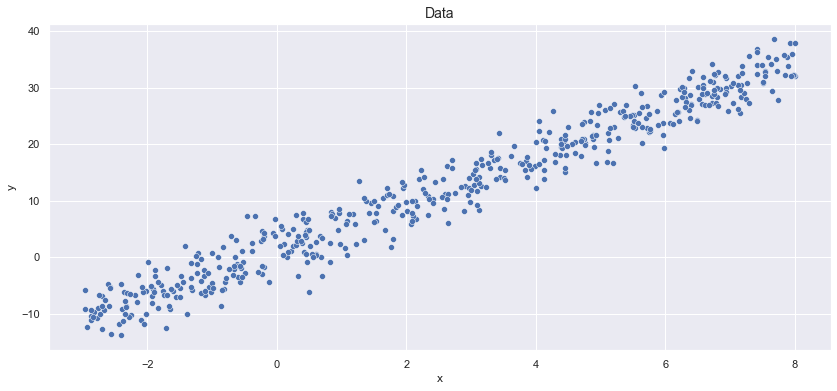

In [108]:
# Generate random datapoints normally distributed around a
# straight line.
n_datapoints = 500

x_data = tf.random.uniform(minval=-3., maxval=8., shape=(n_datapoints, 1))

a_true = 4.1
b_true = 1.2
sigma_data_true = 2.75

y_data = tf.squeeze(tfd.Normal(loc=x_data * a_true + b_true, scale=sigma_data_true).sample())


# Plot generated data.
fig = plt.figure(figsize=(14, 6))

sns.scatterplot(
    x=x_data[:, 0].numpy(),
    y=y_data.numpy()
)

plt.xlabel('x')
plt.ylabel('y')
plt.title('Data', fontsize=14)

## Build the model

Build the needed distribution and function that compute (various parts of) the loss.

The NLL loss is computed using the Monte Carlo approximation of
$$
\text{loss}_\text{NLL} = - \mathbb{E}_{\theta_i \sim \mathcal{N}(\mu_i, \sigma_i)} \left[ \log(p(D \vert a, b)) \right] \simeq - \frac{1}{N} \sum_{j=1}^{N} \log(p(D \vert a_j, b_j))\,,
$$
where $(a_j, b_j)$ are samples from the variational distribution. Following the Bayes by backprop algorithm, we male two nontrivial steps:
- We take $N=1$, computing the Monte Carlo approximation using a single sample. This makes the gradient more noisy but the training procedure quicker (while still converging) and is usually thought to be the best tradeoff.
- We use the **reparametrization trick**. In principle, when computing the gradient we should differentiate the above Monte Carlo approximation w.r.t. the parameters of the variational distribution that generate the $(a_j, b_j)$ samples, which is not possible (we can't differentiate through a sample). In order to make differentiation possible, instead of drawing samples as
$$
\begin{array}{l}
a \sim \mathcal{N}( a | \mu_a, \sigma_a), \\
b \sim \mathcal{N}( b | \mu_b, \sigma_b),
\end{array}
$$

we put
$$
\begin{array}{l}
a \sim \mu_a + \sigma_a\, \epsilon, \\
b \sim \mu_b + \sigma_b\, \epsilon,
\end{array}
$$

where $\epsilon \sim \mathcal{N}(1, 0)$. We can then draw samples $\epsilon_1, \ldots, \epsilon_N$ and compute
$$
\begin{array}{l}
a_j = \mu_a + \sigma_a\, \epsilon_j, \\
b_j = \mu_b + \sigma_b\, \epsilon_j,
\end{array}
$$

which can be differentiated w.r.t. to all the variational parameters because the $\epsilon_j$ are just numbers.

In [109]:
# Prior distributions.
priors = tfd.Normal(loc=[0., 0.], scale=[1., 1.])

# Weights parametrizing the variational distributions (with some
# initial values).
w0 = tf.Variable(0., name='w0')  # --> mu_a
w1 = tf.Variable(1., name='w1')  # --> softplus --> sigma_a
w2 = tf.Variable(0., name='w2')  # --> mu_b
w3 = tf.Variable(1., name='w2')  # --> softplus --> sigma_b

variational_distr = tfd.Normal(
    loc=[w0, w2],
    scale=[tf.math.softplus(w1), tf.math.softplus(w3)]
)

In [110]:
# @tf.function
def compute_loss_kl(mu_a, sigma_a, mu_b, sigma_b):
    """
    Note: variational distributions and priors of different parameters
          are assumed to be independent, therefore the total KL divergence
          is just a sum of the contributions coming from each parameter.
    """
    return (
        - 0.5 * (1 + tf.math.log(tf.square(sigma_a)) - tf.square(mu_a) - tf.square(sigma_a))
        - 0.5 * (1 + tf.math.log(tf.square(sigma_b)) - tf.square(mu_b) - tf.square(sigma_b))
    )

# Test.
compute_loss_kl(
    variational_distr.loc[0],
    variational_distr.scale[0],
    variational_distr.loc[1],
    variational_distr.scale[1]
)

<tf.Tensor: shape=(), dtype=float32, numpy=0.17962837>

In [111]:
def build_likelihood(x_data, a_b_samples):
    """
    """
    return tfd.Independent(
            tfd.Normal(
            loc=a_b_samples[:, :1] * tf.transpose(x_data) + a_b_samples[:, 1:],
            scale=2.
        ),
        reinterpreted_batch_ndims=1
    )

# Test.
a_b_samples = variational_distr.sample(6)

build_likelihood(x_data, a_b_samples)

<tfp.distributions.Independent 'IndependentNormal' batch_shape=[6] event_shape=[500] dtype=float32>

In [112]:
def nll(likelihood, y_data):
    """
    Returns the log likelihood of the dataset (one
    value computed as the sum of the log likelihood
    of each datapoint).
    
    Question: should we use an average over the datapoints
              instead?
    """
    return - likelihood.log_prob(y_data)


# Test.
nll(
    build_likelihood(x_data, a_b_samples),
    y_data
)

<tf.Tensor: shape=(6,), dtype=float32, numpy=
array([19912.771, 17377.352, 11151.74 , 25231.658, 25711.768, 31363.852],
      dtype=float32)>

In [113]:
# @tf.function
def compute_loss_nll(x_data, y_data, variational_distr, n_samples=1):
    """
    """
    # Generate samples for the parameters using the
    # reparametrization trick.
    # Shape: (n_samples, 2).
    a_b_samples = (
        variational_distr.loc
        + variational_distr.scale * tfd.Normal(loc=[0., 0.], scale=[1., 1.]).sample(n_samples)
    )
    
    # Compute a value for the NLL for each sample of a and b.
    nlls_a_b_samples =  nll(
        build_likelihood(x_data, a_b_samples),
        y_data
    )
    
    # Return the MC approximation of the NLL (i.e. the average
    # over the samples of a and b).
    return tf.reduce_mean(nlls_a_b_samples)

# Test.
compute_loss_nll(x_data, y_data, variational_distr, n_samples=5)

<tf.Tensor: shape=(), dtype=float32, numpy=25797.326>

In [165]:
@tf.function
def compute_total_loss(
        x_data,
        y_data,
        variational_distr,
        normalize_loss_nnl=False
    ):
    """
    The `normalize_loss_nnl` parameters manages whether we
    divide the NLL part of the loss by the number of samples
    (the computed value is a sum over samples but we might
    want to use an average as the two parts of the loss potentially
    end up being on very different scales).
    
    Note: training doesn't really work if we add the above
          normalization (the noise seem to be too big).
    """
    loss_kl = compute_loss_kl(
        variational_distr.loc[0],
        variational_distr.scale[0],
        variational_distr.loc[1],
        variational_distr.scale[1]
    )
    
    loss_nll = compute_loss_nll(x_data, y_data, variational_distr, n_samples=1)
    
    if normalize_loss_nnl:
        loss_nll = loss_nll / x_data.shape[0]
    
    total_loss = loss_kl + loss_nll
    
    # print(f'Loss KL: {loss_kl} | Loss NLL: {loss_nll} | Total loss: {total_loss}')
    
    return total_loss


# Test.
compute_total_loss(
    x_data,
    y_data,
    variational_distr
)

<tf.Tensor: shape=(), dtype=float32, numpy=1308.3503>

## Model training

Train the model with gradient descent (once the loss is correctly defined, this is done as usual).

Notice that the total loss is by far dominated by the NLL part which, being the sum of a positive contribution from each sample, tends to grow with the number of samples and is orders of magnitude bigger than the KL part. We included an option to rescale the NLL loss by taking the average over sample (loss per sample), and the training seems to work in that case as well.

In [166]:
def is_in_ellipse(point, maj_axis, min_axis, center):
    """
    Utility function establishing if a point in 2 dimensions belong
    to the ellipse with major axis `maj_axis` and minor axis `min_axis`
    centered in `center`.
    """
    x_shifted = point[0] - center[0]
    y_shifted = point[1] - center[1]
    
    x_min = - maj_axis * tf.sqrt(1. - tf.square(y_shifted / min_axis))
    x_max = maj_axis * tf.sqrt(1. - tf.square(y_shifted / min_axis))
    
    y_min = - min_axis * tf.sqrt(1. - tf.square(x_shifted / maj_axis))
    y_max = min_axis * tf.sqrt(1. - tf.square(x_shifted / maj_axis))
    
    is_x_in_range = (x_shifted >= x_min) and (x_shifted <= x_max)
    is_y_in_range = (y_shifted >= y_min) and (y_shifted <= y_max)
    
    return (is_x_in_range and is_y_in_range)

In [210]:
# Re-initialize weights (for experimenting).
w0 = tf.Variable(5.5, name='w0')  # --> mu_a
w1 = tf.Variable(4.4, name='w1')  # --> softplus --> sigma_a
w2 = tf.Variable(9.5, name='w2')  # --> mu_b
w3 = tf.Variable(1.6, name='w2')  # --> softplus --> sigma_b

variational_distr = tfd.Normal(
    loc=[w0, w2],
    scale=[tf.math.softplus(w1), tf.math.softplus(w3)]
)


normalize_loss_nnl = False

loss_history = [
    compute_total_loss(
        x_data,
        y_data,
        variational_distr,
        normalize_loss_nnl=normalize_loss_nnl
    ).numpy()
]

params_history = [
    [variational_distr.mean()[0].numpy(), variational_distr.mean()[1].numpy()]
]

epoch = 0

print(f'Starting point | Loss: {loss_history[-1]}')

Starting point | Loss: 63961.25390625


In [211]:
epochs = 2000

lr = 1e-4  # 1e-4 works without normalization for the NLL loss, 1e-2 works with it.

optimizer = tf.keras.optimizers.SGD(learning_rate=lr)

print(f'Epoch: {epoch} | Loss: {loss_history[-1]}')

for i in range(epochs):
    with tf.GradientTape() as tape:
        variational_distr = tfd.Normal(
            loc=[w0, w2],
            scale=[tf.math.softplus(w1), tf.math.softplus(w3)]
        )

        loss = compute_total_loss(
            x_data,
            y_data,
            variational_distr,
            normalize_loss_nnl=normalize_loss_nnl
        )

    grad = tape.gradient(loss, [w0, w1, w2, w3])

    optimizer.apply_gradients(zip(grad, [w0, w1, w2, w3]))
    
    loss_history.append(loss.numpy())
    params_history.append([
        variational_distr.mean()[0].numpy(), variational_distr.mean()[1].numpy()
    ])
    
    epoch += 1
    
    if i % 100 == 0:
        print(f'Epoch: {epoch} | Loss: {loss_history[-1]}')
    
    
variational_distr_final = tfd.Normal(
    loc=[w0, w2],
    scale=[tf.math.softplus(w1), tf.math.softplus(w3)]
)

Epoch: 0 | Loss: 63961.25390625
Epoch: 1 | Loss: 42024.12109375
Epoch: 101 | Loss: 2278.783935546875
Epoch: 201 | Loss: 1480.75732421875
Epoch: 301 | Loss: 1378.877685546875
Epoch: 401 | Loss: 1364.099853515625
Epoch: 501 | Loss: 1313.1046142578125
Epoch: 601 | Loss: 1309.7509765625
Epoch: 701 | Loss: 1347.4722900390625
Epoch: 801 | Loss: 1327.11328125
Epoch: 901 | Loss: 1307.4940185546875
Epoch: 1001 | Loss: 1311.8106689453125
Epoch: 1101 | Loss: 1319.865966796875
Epoch: 1201 | Loss: 1307.9222412109375
Epoch: 1301 | Loss: 1307.6630859375
Epoch: 1401 | Loss: 1308.7303466796875
Epoch: 1501 | Loss: 1311.491943359375
Epoch: 1601 | Loss: 1308.7296142578125
Epoch: 1701 | Loss: 1308.493408203125
Epoch: 1801 | Loss: 1309.2735595703125
Epoch: 1901 | Loss: 1309.562255859375


Estimated variational parameters:
mu_a: 4.109136581420898 | sigma_a: 0.03995212912559509 | mu_b: 1.3918036222457886 | sigma_b: 0.18160387873649597

True values:
a: 4.1 | b: 1.2

Distance of the true values from the posterior means:
a: 0.22869060933589935 sigma | b: 1.0561645030975342 sigma


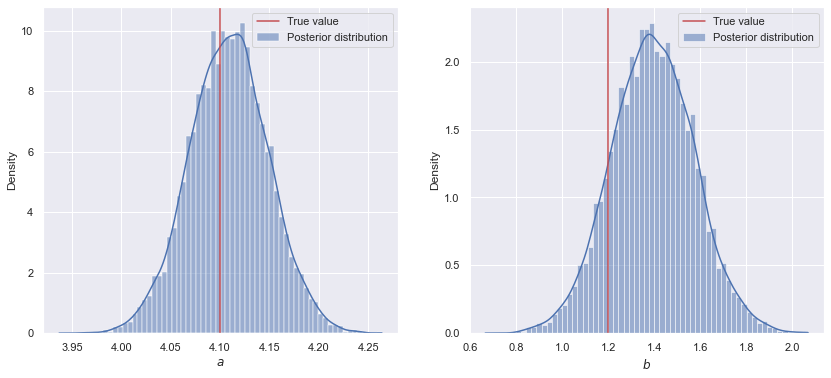

In [212]:
# Plot the variational distributions of the parameters and
# the true values.
print('Estimated variational parameters:')
print(
    f'mu_a: {variational_distr_final.mean()[0]} | '
    f'sigma_a: {variational_distr_final.stddev()[0]} | '
    f'mu_b: {variational_distr_final.mean()[1]} | '
    f'sigma_b: {variational_distr_final.stddev()[1]}'
)

print('\nTrue values:')
print(f'a: {a_true} | b: {b_true}')

z_a = (variational_distr_final.mean()[0] - a_true) / variational_distr_final.stddev()[0]
z_b = (variational_distr_final.mean()[1] - b_true) / variational_distr_final.stddev()[1]

print('\nDistance of the true values from the posterior means:')
print(f'a: {z_a} sigma | b: {z_b} sigma')


fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

final_samples = variational_distr_final.sample(10000)

sns.histplot(
    x=final_samples[:, 0].numpy(),
    ax=axs[0],
    kde=True,
    stat='density',
    label='Posterior distribution'
)

axs[0].axvline(
    x=[a_true],
    ymin=0.,
    ymax=1.,
    color='r',
    label='True value'
)

plt.sca(axs[0])
plt.xlabel('$a$')
plt.legend()


sns.histplot(
    x=final_samples[:, 1].numpy(),
    ax=axs[1],
    kde=True,
    stat='density',
    label='Posterior distribution'
)

axs[1].axvline(
    x=[b_true],
    ymin=0.,
    ymax=1.,
    color='r',
    label='True value'
)

plt.sca(axs[1])
plt.xlabel('$b$')
plt.legend()

Text(0.5, 1.0, 'Joint posterior distributions for $a$ and $b$')

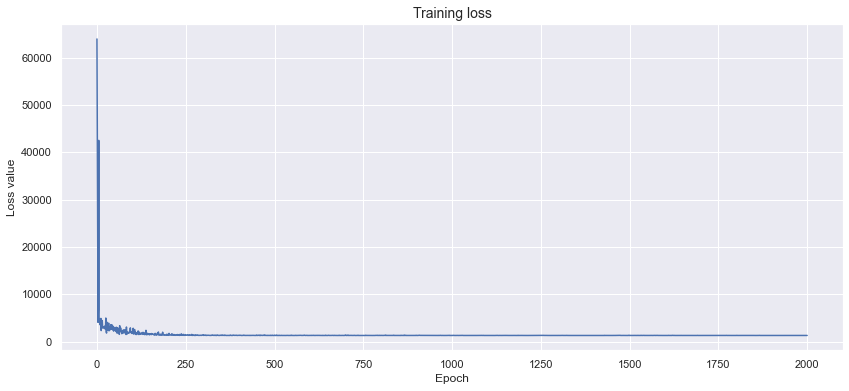

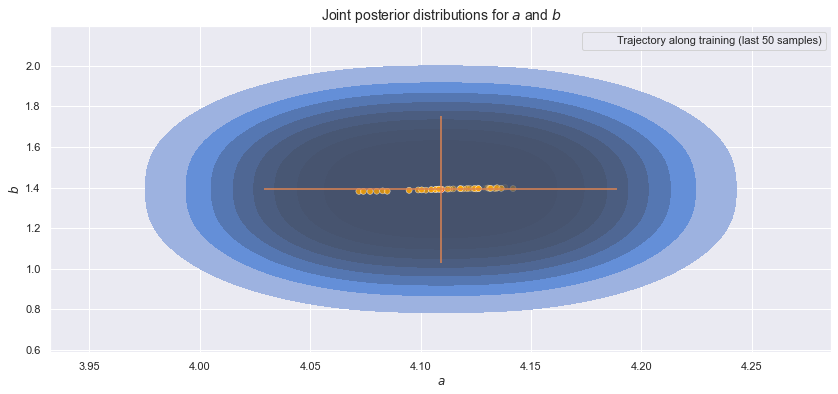

In [213]:
# Loss history
fig = plt.figure(figsize=(14, 6))

sns.lineplot(
    x=range(len(loss_history)),
    y=loss_history
)

plt.title('Training loss', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Loss value')


# 2-dimensional density plot for a and b.
fig = plt.figure(figsize=(14, 6))

# a_b_samples_final = variational_distr_final.sample(5000)
a_plot, b_plot = tf.meshgrid(
    tf.linspace(
        variational_distr_final.mean()[0] - 3. * variational_distr_final.stddev()[0],
        variational_distr_final.mean()[0] + 3. * variational_distr_final.stddev()[0],
        20
    ),
    tf.linspace(
        variational_distr_final.mean()[1] - 3. * variational_distr_final.stddev()[1],
        variational_distr_final.mean()[1] + 3. * variational_distr_final.stddev()[1],
        20
    )
)

a_b_samples_final = tf.stack(
    [
        tf.reshape(a_plot, a_plot.shape[0] * a_plot.shape[1]),
        tf.reshape(b_plot, b_plot.shape[0] * b_plot.shape[1])
    ],
    axis=1
)

a_b_samples_final = tf.stack(
    [
        p for p in list(a_b_samples_final)
        if is_in_ellipse(
            p,
            3. * variational_distr_final.stddev()[0],
            3. * variational_distr_final.stddev()[1],
            variational_distr_final.mean()
        )
    ],
    axis=0
)

sns.kdeplot(
    x=a_b_samples_final[:, 0].numpy(),
    y=a_b_samples_final[:, 1].numpy(),
    fill=True,
)

sns.scatterplot(
    x=variational_distr_final.mean()[:1].numpy(),
    y=variational_distr_final.mean()[1:].numpy(),
    color='red'
)

sns.scatterplot(
    x=tf.constant(params_history)[-50:, 0],
    y=tf.constant(params_history)[-50:, 1],
    color='orange',
    alpha=list(tf.linspace(0., 1., len(params_history[-50:])).numpy()),
    label='Trajectory along training (last 50 samples)'
)

plt.errorbar(
    x=variational_distr_final.mean()[:1].numpy(),
    y=variational_distr_final.mean()[1:].numpy(),
    xerr=2. * variational_distr_final.stddev()[:1].numpy(),
    yerr=2. * variational_distr_final.stddev()[1:].numpy()
)

plt.xlabel('$a$')
plt.ylabel('$b$')
plt.title('Joint posterior distributions for $a$ and $b$', fontsize=14)

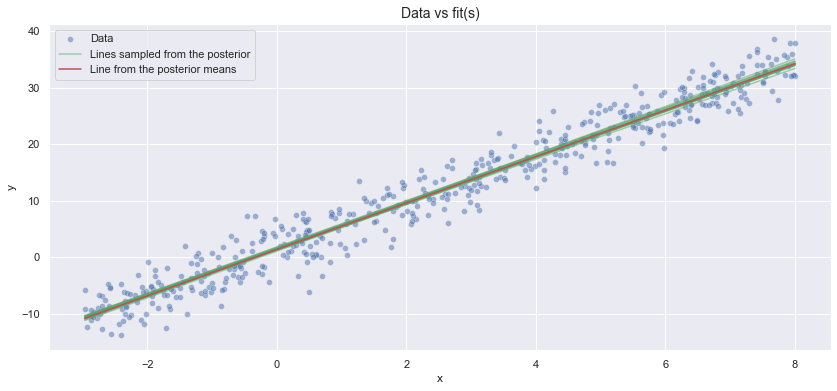

In [214]:
fig = plt.figure(figsize=(14, 6))

x_plot = tf.linspace(x_data.numpy().min(), x_data.numpy().max(), 100)

a_b_samples = variational_distr_final.sample(15)

y_plot = x_plot * a_b_samples[:, :1] + a_b_samples[:, 1:]

sns.scatterplot(
    x=x_data[:, 0].numpy(),
    y=y_data.numpy(),
    alpha=.5,
    label='Data'
)

for line in range(a_b_samples.shape[0]):
    sns.lineplot(
        x=x_plot,
        y=y_plot[line, :],
        alpha=0.5,
        color='g',
        label='Lines sampled from the posterior' if line == 0 else None
    )
    
sns.lineplot(
    x=x_plot,
    y=x_plot * variational_distr_final.mean()[0] + variational_distr_final.mean()[1],
    alpha=1.,
    color='r',
    label='Line from the posterior means'
)
    
plt.xlabel('x')
plt.ylabel('y')
plt.title('Data vs fit(s)', fontsize=14)
plt.legend()